In [7]:
# LOAD LIBRARIES
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import random


# Load libraries for Decision Tree
import pandas as pd
from sklearn.tree import DecisionTreeClassifier  # Import Decision Tree Classifier
from sklearn.model_selection import train_test_split  # Import train_test_split function
from sklearn import metrics  #Import scikit-learn metrics module for accuracy calculation
from sklearn.preprocessing import scale

# Load libraries for Decision Tree Model Plot
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO
from IPython.display import Image
import pydotplus

# Load libaries for various model performance metrics
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, confusion_matrix, average_precision_score, precision_recall_curve
from matplotlib import pyplot as plt
from inspect import signature

# Load libaries for logistic regression
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
import seaborn as sns
sns.set()
#from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pandas as pd

from scipy.spatial import distance

In [8]:
def get_census_data(path_train, path_test):
    # import:
    columns = [
        "age", "workClass", "fnlwgt", "education", "education-num",
        "marital-status", "occupation", "relationship", "race", "sex",
        "capital-gain", "capital-loss", "hours-per-week", "native-country",
        "income"
    ]
    census_train = pd.read_csv(path_train,
                               names=columns,
                               sep=' *, *',
                               na_values='?')
    census_test = pd.read_csv(path_test,
                              names=columns,
                              sep=' *, *',
                              skiprows=1,
                              na_values='?')

    census = pd.concat([census_train, census_test], axis=0)
    
    # clean:
    census['income'] = census['income'].map(lambda x: x.replace('.', ''))
    
    census['income_over_50K'] = None
    census.loc[census.income == '<=50K', 'income_over_50K'] = 0
    census.loc[census.income == '>50K', 'income_over_50K'] = 1
    
    income_over_50K = census.income_over_50K
    census = census.drop(columns=['income_over_50K', 'income'])
    census.insert(0, 'income_over_50K', income_over_50K)
    
    census = census.drop(columns = ['fnlwgt']) # does not have anything to do with data
    
    # Making native-country to country_USA feature instead:
    census['country_USA'] = 0
    census.loc[census['native-country'] == 'United-States', 'country_USA'] = 1
    census = census.drop(columns=['native-country'])
    
    census_with_dummies = pd.get_dummies(data= census,columns=census.select_dtypes(include=['object']).columns,drop_first=True)
    
    return census, census_with_dummies

def explore_data(data, label):    
    num_attributes = data.select_dtypes(include=['int'])
    print('Numerical features: ' + str(num_attributes.columns))
    
    num_attributes.hist(figsize=(10,10))
    
    print(data.describe())
    
    cat_attributes = data.select_dtypes(include=['object'])
    print('Categorical features: ' + str(cat_attributes.columns))
    
    for column in cat_attributes:
        if column != 'income':
            sns.countplot(y=column, hue=data[label], data = cat_attributes)
            plt.show()
    
census, census_with_dummies = get_census_data('adult.data', 'adult.test')

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  if sys.path[0] == '':
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


Numerical features: Index(['income_over_50K', 'age', 'education-num', 'capital-gain',
       'capital-loss', 'hours-per-week', 'country_USA'],
      dtype='object')
       income_over_50K           age  education-num  capital-gain  \
count     48842.000000  48842.000000   48842.000000  48842.000000   
mean          0.239282     38.643585      10.078089   1079.067626   
std           0.426649     13.710510       2.570973   7452.019058   
min           0.000000     17.000000       1.000000      0.000000   
25%           0.000000     28.000000       9.000000      0.000000   
50%           0.000000     37.000000      10.000000      0.000000   
75%           0.000000     48.000000      12.000000      0.000000   
max           1.000000     90.000000      16.000000  99999.000000   

       capital-loss  hours-per-week   country_USA  
count  48842.000000    48842.000000  48842.000000  
mean      87.502314       40.422382      0.897424  
std      403.004552       12.391444      0.303407  
min  

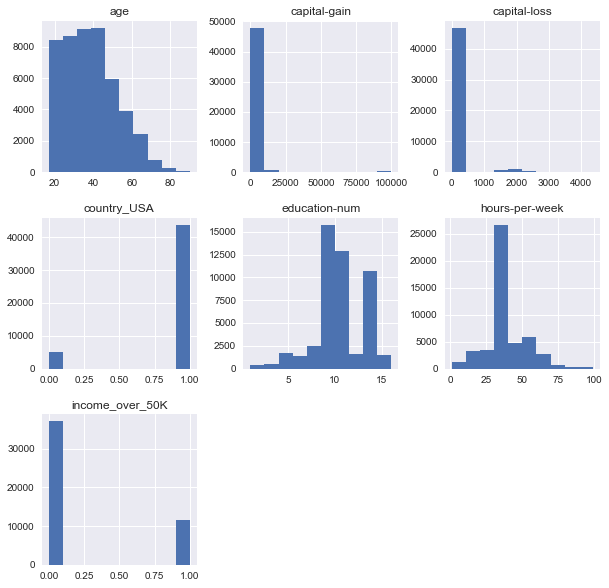

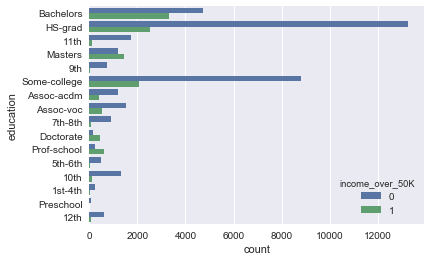

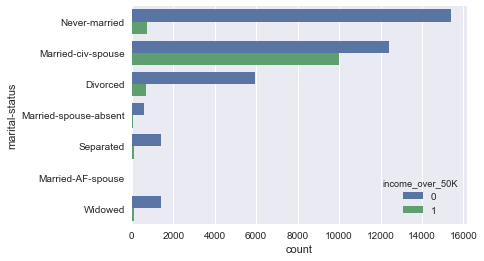

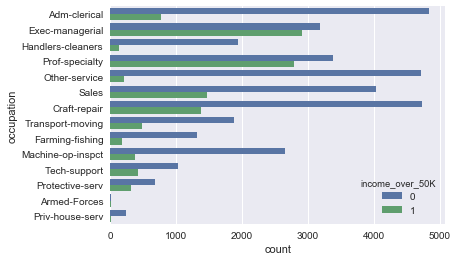

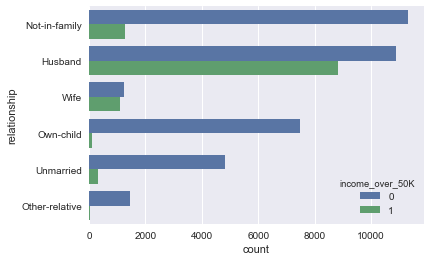

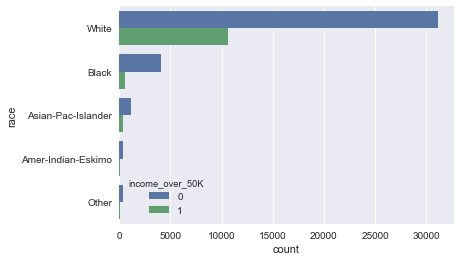

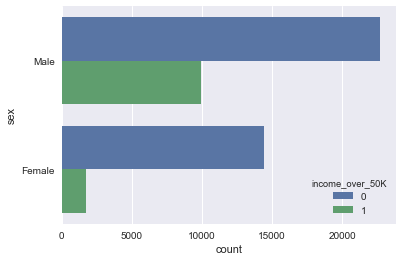

In [9]:
explore_data(census, 'income_over_50K')

In [10]:
census_with_dummies.head()

,income_over_50K,age,education-num,capital-gain,capital-loss,hours-per-week,country_USA,workClass_Local-gov,workClass_Never-worked,workClass_Private,...,relationship_Not-in-family,relationship_Other-relative,relationship_Own-child,relationship_Unmarried,relationship_Wife,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Male
0,0,39,13,2174,0,40,1,0,0,0,...,1,0,0,0,0,0,0,0,1,1
1,0,50,13,0,0,13,1,0,0,0,...,0,0,0,0,0,0,0,0,1,1
2,0,38,9,0,0,40,1,0,0,1,...,1,0,0,0,0,0,0,0,1,1
3,0,53,7,0,0,40,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
4,0,28,13,0,0,40,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0


In [11]:
from sklearn.model_selection import train_test_split


In [28]:
y = census_with_dummies.iloc[:, 0]
X = census_with_dummies.drop(census_with_dummies.columns[0], axis=1)

feature_names = census_with_dummies.columns[1:]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

In [29]:
#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

y_pred=clf.predict(X_test)

In [30]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8463795809731796


In [31]:
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

age                                     0.234602
hours-per-week                          0.120131
capital-gain                            0.115931
marital-status_Married-civ-spouse       0.101581
education-num                           0.071286
capital-loss                            0.035451
marital-status_Never-married            0.033902
occupation_Exec-managerial              0.022272
sex_Male                                0.019467
occupation_Prof-specialty               0.016648
relationship_Not-in-family              0.015179
workClass_Private                       0.014470
education_Bachelors                     0.012366
country_USA                             0.011948
workClass_Self-emp-not-inc              0.009780
relationship_Own-child                  0.009188
relationship_Wife                       0.008487
occupation_Sales                        0.008222
race_White                              0.007993
relationship_Unmarried                  0.007970
education_Masters   

No handles with labels found to put in legend.


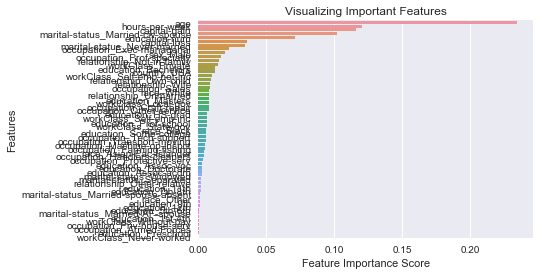

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

In [40]:
y_score = clf.predict_proba(X_test)
y_score = y_score[:,1] # gives estimated probabilities of class = 1

In [41]:
from sklearn.metrics import average_precision_score
average_precision = average_precision_score(y_test, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.73


In [42]:
confusion_matrix(y_test, y_pred)

array([[10308,   925],
       [ 1326,  2094]])

In [45]:
from sklearn.model_selection import cross_val_score
import numpy as np
#create a new KNN model
knn_cv = KNeighborsClassifier(n_neighbors=3)
#train model with cv of 5 
cv_scores = cross_val_score(knn_cv, X, y, cv=5)
#print each cv score (accuracy) and average them
print(cv_scores)
print(‘cv_scores mean:{}’.format(np.mean(cv_scores)))

SyntaxError: invalid character in identifier (<ipython-input-45-901b0b9b1895>, line 10)

In [46]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
#create new a knn model
knn = KNeighborsClassifier()
#create a dictionary of all values we want to test for n_neighbors
param_grid = {'n_neighbors': np.arange(1, 25)}
#use gridsearch to test all values for n_neighbors
knn_gscv = GridSearchCV(knn, param_grid, cv=5)
#fit model to data
knn_gscv.fit(X, y)

KeyboardInterrupt: 